In [42]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


import pandas as pd
from simulation import run_simulation
from datetime import timedelta
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import networkx as nx
import random
import metis
from collections import defaultdict
from datetime import timedelta, datetime
from tqdm import tqdm

from rwc import controversy_score
from util import tw_list, get_cut_ratio, add_edges, remove_edges
from leopard import update_partition

DEBUG = False


# prevent pickling error in multiprocessing
def defaultdict_using_list_func():
    return defaultdict(list)


def earlist_date_func():
    return datetime(1970, 1, 1)

In [3]:
retweets = pd.read_pickle('data/july.pkl')
text = pd.read_pickle('data/july_text.pkl')

In [4]:
incremental = True
update_interval = timedelta(minutes=10)
T_window = timedelta(minutes=6*60)
top_node_percent=0.01

result = run_simulation(retweets,
                        T_window=T_window,
                        head_n=5*1e5,
                        incremental=True,
                        update_interval=update_interval,
                        top_node_percent=top_node_percent,
                        top_k_computation_interval=timedelta(minutes=20))

500000it [08:31, 978.16it/s] 


In [16]:
result[1]

[{'list': [], 'time': Timestamp('2016-07-04 14:11:54.660000')},
 {'list': [], 'time': Timestamp('2016-07-04 14:51:00.658000')},
 {'list': [], 'time': Timestamp('2016-07-04 19:50:00.662000')},
 {'list': [{'rwc': 0.94115997602480828, 'size': 230, 'tag': 'VeranoMTV2016'},
   {'rwc': 0.95875176485661262, 'size': 214, 'tag': 'MSGsays2Farmers'}],
  'time': Timestamp('2016-07-11 18:50:00.657000')},
 {'list': [{'rwc': 0.92769737823546827,
    'size': 661,
    'tag': 'ALDUBIYAMin2Days'},
   {'rwc': 0.94115997602480828, 'size': 212, 'tag': 'VeranoMTV2016'},
   {'rwc': 0.85865982601084301, 'size': 119, 'tag': 'MGWV'},
   {'rwc': 0.95875176485661262, 'size': 2, 'tag': 'MSGsays2Farmers'}],
  'time': Timestamp('2016-07-11 22:50:00.660000')},
 {'list': [{'rwc': 0.90066559487931197,
    'size': 866,
    'tag': 'ALDUBIYAMin2Days'},
   {'rwc': 0.96263883369381698, 'size': 361, 'tag': 'MSGsaysHardwork'},
   {'rwc': 0.8692221602250414, 'size': 140, 'tag': 'MGWV'},
   {'rwc': 0.95875176485661262, 'size': 2

In [5]:
top_k_log = result[1]
tags = list(set([i['tag'] for l in top_k_log for i in l['list']]))
print(tags)

['MTVHottest', 'AsantewaaDeBlogger', 'ALDUBIYAMin2Days', '727TourManchester', 'FOLLOW', 'ThreeEmptyWordsAtMidnight', 'SoundCloud', 'SLFLMSG', 'HealthTipsByMSG', 'ALDUBMaineCelebration', '4YearsOfFifthHarmony', 'ALDUB54thWeeksary', 'Sultan', 'VeranoMTV2016', 'ALDUBAnniversarEVE', 'ALDUBIYAMin5Days', 'ALDUBAngKapalit', 'MGWV', 'Lyft', 'TrumpTrain', 'MSGsaysHardwork', 'fashion', '727Tour', 'ALDUBSafeZone', 'love', 'MSGsaysLeaveJealousy', 'uber', 'ChoiceSnapchatter', 'UrbanAttires', 'MSGsays2Farmers', 'VoteCaptainCanada', 'ALDUB1stAnniversary', 'enlightenment', 'MSG4YourHealth']


In [67]:
from util import build_graph_from_df
tag = 'MSGsays2Farmers'
retweets_subset = retweets.head(int(5*1e5))
sub_df = retweets_subset[retweets_subset['hashtag'] == tag]


g = build_graph_from_df(sub_df)
pr = nx.pagerank(g)
cuts, cluster_ids = metis.part_graph(g, 2)


partition = defaultdict(list)
for n, c in zip(g.nodes(), cluster_ids):
    partition[c].append(n)

topk0 = sorted(partition[0], key=lambda k: pr[k], reverse=True)[:5]
topk1 = sorted(partition[1], key=lambda k: pr[k], reverse=True)[:5]
print(topk0)
print(topk1)

def all_tweets_ids_by_users(df, users):
    tweets = []
    ids = set()
    for u in users:
        ids |= set(df[(df['retweetee'] == u) | (df['retweeter'] == u)]['message_id'].as_matrix().tolist())
    return ids
        
top_user_tweets_0 = all_tweets_ids_by_users(sub_df, topk0)
top_user_tweets_1 = all_tweets_ids_by_users(sub_df, topk1)

[2893530846, 2853120986, 2853078955, 2866419175, 334770866]
[2852359916, 2862558397, 2880348632, 2824987642, 3029260684]


In [68]:
text0 = text.loc[top_user_tweets_0]['body'].tolist()
text1 = text.loc[top_user_tweets_1]['body'].tolist()
text0, text1 = map(set, [text0, text1])

In [69]:
for t in random.sample(text0, 5):
    print('-'*10)
    print(t)


----------
RT @babitatyagi0: Dr.@Gurmeetramrahim g !as far as i think it is called Organic Farming !Thank You for giving precious suggestions !!
#MSGs…
----------
RT @ksushma140: Drv@Gurmeetramrahim THANX!! INFINITE!! time MY TRUE CARE TAKER ALMIGHTY!! GURU JI #MSGsays2Farmers
----------
RT @babitatyagi0: @Gurmeetramrahim g !!Good news for ALL !!
#MSGsays2Farmers https://t.co/CKT5C21rXd
----------
RT @babitatyagi0: @Gurmeetramrahim Thank YOU My true care taker Almighty g !!
#MSGsays2Farmers
----------
RT @babitatyagi0: @Gurmeetramrahim Your Ultimate Tips will uproot diseases from our society &amp; soon we will see a healthy country !
#MSGsays…


In [70]:
for t in random.sample(text1, 5):
    print('-'*10)
    print(t)


----------
RT @MukhijaNidhi: @Gurmeetramrahim And it is a beautiful picture Guru Ji #MSGsays2Farmers
----------
RT @MukhijaNidhi: Everyday is now a blessing with Guru ji, Dr MSG Himself providing us great tips for living a happy purposeful life #MSGsa…
----------
RT @Gurmeetramrahim: #MSGsays2Farmers God bless you all https://t.co/E1duZ2j7Rw
----------
RT @poojakamboj176: Dr @Gurmeetramrahim Guru ji,
Eat organic n
Stay healthy!!!!  #MSGsays2Farmers
----------
RT @poojakamboj176: @Gurmeetramrahim 
#MSGsays2Farmers 
Guru ji, you are our world's best guider!!! Salute to you Guru ji!!!


In [71]:
from rwc import controversy_score
cuts, cluster_ids = metis.part_graph(g, 2)
rwc, _ = controversy_score(g, node2cluster=dict(zip(g.nodes(), cluster_ids)), top_percent=0.1)
print('before CC', rwc)

before CC 0.945621286846


In [72]:
from util import get_largest_connected_subgraph
g = get_largest_connected_subgraph(g)
cuts, cluster_ids = metis.part_graph(g, 2)

rwc, _ = controversy_score(g, node2cluster=dict(zip(g.nodes(), cluster_ids)), top_percent=0.1)
print('after CC', rwc)

after CC 0.912344609613



 40%|████      | 40/100 [00:00<00:00, 60.71it/s]Exception in thread Thread-22:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/cloud-user/code/controversy_detection/venv/lib/python3.5/site-packages/tqdm/_tqdm.py", line 102, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 100/100 [00:01<00:00, 60.86it/s]


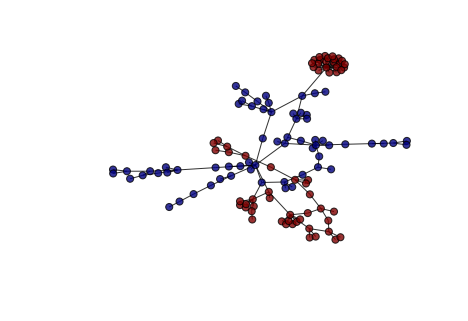

In [73]:
from forceatlas import forceatlas2_layout
from util import get_largest_connected_subgraph

pos = forceatlas2_layout(g, iterations=100)
fig = nx.draw(g, pos=pos, with_label=False, node_color=cluster_ids, node_size=50, alpha=0.8)
fig = plt.gcf()
fig.savefig('figs/{}.pdf'.format(tag))